In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train9_dtypes.csv')
test_dtypes = pd.read_csv('../input/test9_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train_PI_1ekim.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 23.1 s, sys: 1.11 s, total: 24.2 s
Wall time: 24.2 s


In [7]:
%%time
test = pd.read_csv('../input/test_PI_1ekim.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 19.5 s, sys: 760 ms, total: 20.2 s
Wall time: 20.2 s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 359) (506691, 358) (506691, 2)


In [9]:
group_columns = [x for x in train.columns if 'group' in x]

In [10]:
print(group_columns)
print(len(group_columns))

['group_1_mean', 'group_1_median', 'group_1_min', 'group_1_max', 'group_1_sum', 'group_1_std', 'group_1_kurtosis', 'group_2_mean', 'group_2_median', 'group_2_min', 'group_2_max', 'group_2_sum', 'group_2_std', 'group_2_kurtosis', 'group_3_mean', 'group_3_median', 'group_3_min', 'group_3_max', 'group_3_sum', 'group_3_std', 'group_3_kurtosis', 'group_4_mean', 'group_4_median', 'group_4_min', 'group_4_max', 'group_4_sum', 'group_4_std', 'group_4_kurtosis', 'group_5_mean', 'group_5_median', 'group_5_min', 'group_5_max', 'group_5_sum', 'group_5_std', 'group_5_kurtosis', 'group_6_mean', 'group_6_median', 'group_6_min', 'group_6_max', 'group_6_sum', 'group_6_std', 'group_6_kurtosis', 'group_7_mean', 'group_7_median', 'group_7_min', 'group_7_max', 'group_7_sum', 'group_7_std', 'group_7_kurtosis', 'group_8_mean', 'group_8_median', 'group_8_min', 'group_8_max', 'group_8_sum', 'group_8_std', 'group_8_kurtosis', 'group_9_mean', 'group_9_median', 'group_9_min', 'group_9_max', 'group_9_sum', 'group_9

In [11]:
shared = ['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc',
 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5',
 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 
 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 
 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 
 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44',
 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fraudulent', 'card3_185.0', 
 'card3_DeviceInfo', 'card3_TransactionAmt_mean', 'card4_count_full', 'card5_TransactionAmt_mean', 'card5_TransactionAmt_std', 'card6', 'card6_count_full',
 'device_name_fq_enc', 'dist1_91.0', 'email_check', 'group_10_kurtosis', 'group_5_mean', 'group_5_median', 'group_6_kurtosis', 'id03subtractid04',
 'id03sumid04', 'id13_52.0', 'id14_999999', 'id14_999999.0', 'id19_321.0', 'id19_427.0', 'id20_127.0', 'id20_333.0', 'id20_417.0', 'id20_507.0',
 'id20_638.0', 'id31_firefox', 'id31_opera', 'id33_1280x720', 'id33_2208x1242', 'id_01', 'id_03', 'id_17', 'id_31', 'is_debit', 
 'uid2_TransactionAmt_mean', 'uid3', 'uid_TransactionAmt_mean']

In [12]:
only_gain = ['C13_fq_enc', 'C5', 'C7_fq_enc', 'C_nansum', 'DeviceInfo_Trident/7.0', 'TransactionAmt_decimal_0.0', 'V103', 'V138', 'V140',
             'V153', 'V16', 'V170', 'V172', 'V175', 'V180', 'V188', 'V190', 'V192', 'V194', 'V199', 'V205', 'V220', 'V225', 'V227',
             'V232', 'V237', 'V239', 'V244', 'V246', 'V251', 'V262', 'V266', 'V282', 'V283', 'V29', 'V294', 'V295', 'V296', 'V313', 
             'V315', 'V317', 'V322', 'V323', 'V324', 'V326', 'V331', 'V47', 'V48', 'V54', 'V55', 'V66', 'V69', 'V70', 'V76', 'V85',
             'V90', 'V91', 'V_nanmedian', 'addr2_fq_enc', 'card2_TransactionAmt_std', 'card3_TransactionAmt_std', 'card3_addr2',
             'card3_count_full', 'card3_fq_enc', 'dist1_86.0', 'group_15_max', 'group_15_mean', 'group_15_median', 'group_4_std',
             'group_5_std', 'group_6_sum', 'id09sumid10', 'id19_216.0', 'id33_firstframe', 'id_32']

In [13]:
only_split = ['C_nanstd', 'D14', 'D8', 'DT_D', 'DT_M_total', 'DT_W', 'DT_W_total', 'P_emaildomain_fq_enc', 'P_emaildomain_prefix',
              'ProductCD_addr1', 'R_emaildomain_fq_enc', 'TransactionAmt', 'TransactionAmt_check', 'TransactionAmt_decimal',
              'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4', 'V200', 'V215', 'V241', 'V253', 'V254', 'V255', 
              'V277', 'V278', 'V39', 'addr1', 'addr1_addr2', 'addr1_fq_enc', 'addr2', 'card1', 'card1_addr1', 'card1_count_full',
              'card1_fq_enc', 'card2', 'card2_TransactionAmt_mean', 'card2_fq_enc', 'card4', 'device_name', 'group_5_kurtosis', 
              'group_6_max', 'group_6_mean', 'group_7_max', 'group_9_std', 'id05subtractid06', 'id05sumid06', 'id09subtractid10',
              'id13_27.0', 'id13_999999', 'id18_15.0', 'id19_153.0', 'id19_266.0', 'id19_384.0', 'id20_325.0', 'id_06', 'id_13',
              'id_14', 'id_16', 'id_20', 'id_38', 'relative_hour', 'uid2', 'uid2_fq_enc', 'uid3_TransactionAmt_mean',
              'uid3_TransactionAmt_std', 'uid3_fq_enc', 'uid4', 'uid_DT_M', 'uid_DT_W', 'uid_fq_enc']

In [14]:
all_columns = shared + only_gain + only_split

In [15]:
print(all_columns)
print(len(all_columns))

['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc', 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5', 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44', 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fr

In [16]:
train = train[['isFraud','TransactionID'] + all_columns]
test = test[['TransactionID'] + all_columns]

In [17]:
print(train.shape,test.shape)

(590540, 269) (506691, 268)


# Training

In [18]:
train.drop(['relative_hour'],axis=1,inplace=True)
test.drop(['relative_hour'],axis=1,inplace=True)
gc.collect()

0

In [19]:
train.drop(['TransactionID'],axis=1,inplace=True)
test.drop(['TransactionID'],axis=1,inplace=True)
gc.collect()

14

In [20]:
dropped_columns = ['V300','V309','V111','V124','V106','V125','V315','V134','V102','V123','V316','V113',
'V136','V305','V110','V299','V289','V286','V318','V304','V116','V284','V293',
'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120',
'V1','V14','V41','V65','V88', 'V89', 'V107', 'V68', 'V28', 'V27', 
'V29', 'V241','V269','V240', 'V325', 'V138', 'V154', 'V153', 'V330', 'V142', 'V195', 'V302', 'V328', 'V327',
'V198', 'V196', 'V155']

In [21]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [22]:
[x for x in dropped_columns if x in useful_features]

['V315', 'V289', 'V304', 'V303', 'V29', 'V138', 'V154', 'V195']

In [24]:
print(dropped_columns)

['V300', 'V309', 'V111', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V304', 'V116', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120', 'V1', 'V14', 'V41', 'V65', 'V88', 'V89', 'V107', 'V68', 'V28', 'V27', 'V29', 'V241', 'V269', 'V240', 'V325', 'V138', 'V154', 'V153', 'V330', 'V142', 'V195', 'V302', 'V328', 'V327', 'V198', 'V196', 'V155']


In [25]:
temp_columns = [x for x in train.columns if (x in dropped_columns) & (x not in useful_features)]
print(temp_columns)
train.drop(temp_columns,axis=1,inplace=True)
test.drop(temp_columns,axis=1,inplace=True)
print(train.shape,test.shape)
gc.collect()

['V198', 'V153', 'V295', 'V241']
(590540, 263) (506691, 262)


14

In [31]:
train[[x for x in train.columns if x[0] =='C']].head()

,C1,C10,C10_fq_enc,C11,C11_fq_enc,C12,C12_fq_enc,C13,C14,C14_fq_enc,C1_fq_enc,C2,C2_fq_enc,C3,C4,C4_fq_enc,C6_fq_enc,C7,C8,C8_fq_enc,C13_fq_enc,C5,C7_fq_enc,C_nansum,C_nanstd
0,1.0,0.0,824420,2.0,168780,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,367617,0.0,961237,8.0,0.6226
1,1.0,0.0,824420,1.0,731792,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,367617,0.0,961237,6.0,0.4949
2,1.0,0.0,824420,1.0,731792,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,367617,0.0,961237,7.0,0.5000
3,2.0,0.0,824420,1.0,731792,0.0,856080,25.0,1.0,598520,197520,5.0,31682,0.0,0.0,823454,34225,0.0,0.0,816304,5659,0.0,961237,39.0,6.3480
4,1.0,1.0,192574,1.0,731792,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,1.0,202326,367617,0.0,961237,8.0,0.4949


In [33]:
train[[x for x in train.columns if x[0] =='D']].head()

,D13,DT_M,DeviceInfo,DeviceInfo_999999,DeviceInfo_fq_enc,DeviceType,DeviceType_mobile,DeviceInfo_Trident/7.0,D14,D8,DT_D,DT_M_total,DT_W,DT_W_total
0,-999.0,12,2564,0,863508,2,0,0,-999.0,-999.0,335,137321,48,12093
1,-999.0,12,2564,0,863508,2,0,0,-999.0,-999.0,335,137321,48,12093
2,-999.0,12,2564,0,863508,2,0,0,-999.0,-999.0,335,137321,48,12093
3,-999.0,12,2564,0,863508,2,0,0,-999.0,-999.0,335,137321,48,12093
4,-999.0,12,1663,1,9,1,1,0,-999.0,-999.0,335,137321,48,12093


In [37]:
dropped_columns = ['C13','C14','id_13','id_31','TransactionAmt_to_mean_card4']

In [38]:
print(dropped_columns)
train.drop(dropped_columns,axis=1,inplace=True)
test.drop(dropped_columns,axis=1,inplace=True)
print(train.shape,test.shape)
gc.collect()

['C13', 'C14', 'id_13', 'id_31', 'TransactionAmt_to_mean_card4']
(590540, 258) (506691, 257)


53

In [39]:
train.head()

,isFraud,C1,C10,C10_fq_enc,C11,C11_fq_enc,C12,C12_fq_enc,C14_fq_enc,C1_fq_enc,C2,C2_fq_enc,C3,C4,C4_fq_enc,C6_fq_enc,C7,C8,C8_fq_enc,D13,DT_M,DeviceInfo,DeviceInfo_999999,DeviceInfo_fq_enc,DeviceType,DeviceType_mobile,M4,M5,M6,P_emaildomain,Pemaildomain_DeviceInfo,Pemaildomain_mail.com,Pemaildomain_outlook.com,Pemaildomain_protonmail,ProductCD,ProductCD_DeviceInfo,ProductCD_card3,ProductCD_card5,ProductCD_dist2,R_emaildomain,R_emaildomain_bin,R_emaildomain_prefix,Remaildomain_DeviceInfo,Remaildomain_icloud.com,Remaildomain_lesscategory,Remaildomain_protonmail,V149,V152,V154,V156,V187,V189,V201,V243,V245,V248,V249,V252,V256,V257,V258,V259,V261,V281,V33,V34,V44,V45,V57,V58,V61,V62,V67,V79,V81,V82,V83,V86,V87,V94,card1_fraudulent,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_TransactionAmt_mean,card4_count_full,card5_TransactionAmt_mean,card5_TransactionAmt_std,card6,card6_count_full,device_name_fq_enc,dist1_91.0,email_check,group_10_kurtosis,group_5_mean,group_5_median,group_6_kurtosis,id03subtractid04,id03sumid04,id13_52.0,id14_999999,id14_999999.0,id19_321.0,id19_427.0,id20_127.0,id20_333.0,id20_417.0,id20_507.0,id20_638.0,id31_firefox,id31_opera,id33_1280x720,id33_2208x1242,id_01,id_03,id_17,is_debit,uid2_TransactionAmt_mean,uid3,uid_TransactionAmt_mean,C13_fq_enc,C5,C7_fq_enc,C_nansum,DeviceInfo_Trident/7.0,TransactionAmt_decimal_0.0,V103,V138,V140,V16,V170,V172,V175,V180,V188,V190,V192,V194,V199,V205,V220,V225,V227,V232,V237,V239,V244,V246,V251,V262,V266,V282,V283,V29,V294,V296,V313,V315,V317,V322,V323,V324,V326,V331,V47,V48,V54,V55,V66,V69,V70,V76,V85,V90,V91,V_nanmedian,addr2_fq_enc,card2_TransactionAmt_std,card3_TransactionAmt_std,card3_addr2,card3_count_full,card3_fq_enc,dist1_86.0,group_15_max,group_15_mean,group_15_median,group_4_std,group_5_std,group_6_sum,id09sumid10,id19_216.0,id33_firstframe,id_32,C_nanstd,D14,D8,DT_D,DT_M_total,DT_W,DT_W_total,P_emaildomain_fq_enc,P_emaildomain_prefix,ProductCD_addr1,R_emaildomain_fq_enc,TransactionAmt,TransactionAmt_check,TransactionAmt_decimal,TransactionAmt_to_std_card4,V200,V215,V253,V254,V255,V277,V278,V39,addr1,addr1_addr2,addr1_fq_enc,addr2,card1,card1_addr1,card1_count_full,card1_fq_enc,card2,card2_TransactionAmt_mean,card2_fq_enc,card4,device_name,group_5_kurtosis,group_6_max,group_6_mean,group_7_max,group_9_std,id05subtractid06,id05sumid06,id09subtractid10,id13_27.0,id13_999999,id18_15.0,id19_153.0,id19_266.0,id19_384.0,id20_325.0,id_06,id_14,id_16,id_20,id_38,uid2,uid2_fq_enc,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid3_fq_enc,uid4,uid_DT_M,uid_DT_W,uid_fq_enc
0,0,1.0,0.0,824420,2.0,168780,0.0,856080,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,-999.0,12,2564,0,863508,2,0,2,0,1,12,19,0,0,0,4,283,37,81,64,12,6,12,31,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,0,143,147.625,9524,185.250,999.000,1,267648,863508,0,0,NaN,0.4092,0.0,-1.720,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,0,258.0000,14931,258.0000,367617,0.0,961237,8.0,0,0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,117.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,956415,-999.000,255.25,30,956845,956845,0,NaN,NaN,NaN,0.4990,0.5034,7.0,NaN,0,888888,-999.0,0.6226,-999.0,-999.0,335,137321,48,12093,163648,12,174,824070,4.242188,1,500,0.1703,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,315.0,25,43035,87.0,13926,15822,56,56,-999.0,-999.000,17587,1,2172,-2.037,1.0,0.35,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,-999.0,-999.0,2,-999.0,2,4765,6,193.0000,176.1250,2,4,0.000015,0.000083,6
1,0,1.0,0.0,824420,1.0,731792,0.0,856080,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,-999.0,12,2564,0,863508,2,0,0,1,1,17,21

In [40]:
y = train['isFraud']
del train['isFraud']

In [41]:
print(train.shape,test.shape)

(590540, 257) (506691, 257)


In [42]:
########################### Model params
lgb_params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [43]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    #params, dtrain, 1600, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500
    clf = lgb.train(lgb_params, trn_data ,2000 ,valid_sets=[trn_data, val_data], verbose_eval=200,early_stopping_rounds=100)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972891	valid_1's auc: 0.902002
[400]	training's auc: 0.989195	valid_1's auc: 0.914875
[600]	training's auc: 0.99589	valid_1's auc: 0.922791
[800]	training's auc: 0.998555	valid_1's auc: 0.926736
[1000]	training's auc: 0.999492	valid_1's auc: 0.928469
[1200]	training's auc: 0.999832	valid_1's auc: 0.929435
[1400]	training's auc: 0.999946	valid_1's auc: 0.929751
[1600]	training's auc: 0.999982	valid_1's auc: 0.929955
Early stopping, best iteration is:
[1615]	training's auc: 0.999984	valid_1's auc: 0.930017
Fold 1 ROC AUC Score 0.9300166358422258

Fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971989	valid_1's auc: 0.928059
[400]	training's auc: 0.989321	valid_1's auc: 0.93722
[600]	training's auc: 0.996274	valid_1's auc: 0.941595
[800]	training's auc: 0.998848	valid_1's auc: 0.943194
[1000]	training's auc: 0.999636	valid_1's auc: 0.944215
Early stop

In [44]:
print(roc_auc_score(y,oof))

0.9406894669660474


In [45]:
importance['avg'] = importance.mean(axis=1)

In [46]:
importance = importance.sort_values(by='avg',ascending=False)

In [47]:
importance = importance.reset_index(drop=False)

In [48]:
importance

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,DT_D,28050,17832,11988,19526,14755,18430.2
1,uid3_TransactionAmt_mean,22232,14713,14274,16192,16590,16800.2
2,uid3_fq_enc,23468,15532,10590,16975,12941,15901.2
3,uid3,21200,15720,10104,16876,12965,15373.0
4,uid_DT_W,21510,13138,11170,14899,14582,15059.8
5,uid_DT_M,21110,14022,10390,14623,12980,14625.0
6,TransactionAmt_to_std_card4,21258,12878,9256,14006,11171,13713.8
7,uid2_TransactionAmt_mean,18688,12802,9911,14375,12227,13600.6
8,uid_TransactionAmt_mean,18560,13685,8655,14555,12035,13498.0
9,card1_count_full,19712,12746,7988,14050,11712,13241.6


In [49]:
importance.to_csv('../importances/importances36.csv',index=False)

In [50]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [51]:
sample_submission['isFraud'] = y_pred

In [52]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000548
1,3663550,0.001248
2,3663551,0.001375
3,3663552,0.001454
4,3663553,0.000889


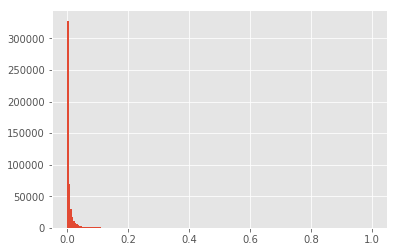

In [53]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [54]:
sample_submission.to_csv('../predictions/pred36.csv',index=False)

In [55]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred36.csv -m "pred36"

100%|███████████████████████████████████████| 14.2M/14.2M [00:34<00:00, 425kB/s]
Successfully submitted to IEEE-CIS Fraud Detection